# Data Cleansing with R

In [1]:
library(dplyr)
library(ggplot2)
if(!require(ggExtra)) {install.packages("ggExtra");require(ggExtra)}
if(!require(naniar)) {install.packages("naniar");require(naniar)}
if(!require(mvoutlier)) {install.packages("mvoutlier");require(mvoutlier)}
if(!require(MissMech)) {install.packages("MissMech");require(MissMech)}
if(!require(mice)) {install.packages("mice");require(mice)}
if(!require(MatchIt)) {install.packages("MatchIt");require(MatchIt)}


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: ggExtra
Warning message:
"package 'ggExtra' was built under R version 3.5.2"Loading required package: naniar
Warning message:
"package 'naniar' was built under R version 3.5.2"Loading required package: mvoutlier
Warning message:
"package 'mvoutlier' was built under R version 3.5.2"Loading required package: sgeostat
Warning message:
"package 'sgeostat' was built under R version 3.5.2"sROC 0.1-2 loaded
Loading required package: MissMech
Warning message:
"package 'MissMech' was built under R version 3.5.2"Loading required package: mice
Warning message:
"package 'mice' was built under R version 3.5.2"Loading required package: lattice

Attaching package: 'mice'

The following objects are masked from 'package:base':

    cbind, rbind

Loading required package: MatchIt
War

In [2]:
outlierMatrix <- function(data,threshold=1.5) {
    vn <- names(data)
    outdata <- data.frame(row1=1:nrow(data))
    for(v in vn) {
        if(is.numeric(data[[v]])) {
            outlow <- quantile(data[[v]],probs = 0.25,na.rm = T) 
            outhigh <- quantile(data[[v]],probs = 0.75, na.rm = T)
            irq_level <- (outhigh - outlow) * threshold
            outlow <- outlow - irq_level
            outhigh <- outhigh +  irq_level
            mv <- ifelse(data[[v]] < outlow | data[[v]] > outhigh, 1, 0)
            outdata[v] <- mv
        } else {
            mv <- rep(0,nrow(data))
        }
    }
    outdata$row1 <- NULL
    return(outdata)
}


missingMatrix <- function(data) {
    vn <- names(data)
    missdata <- data.frame(row1=1:nrow(data))
    for(v in vn) {
        mv <- ifelse(is.na(data[[v]]),1,0)
        missdata[v] <- mv
    }
    missdata$row1 <- NULL
    return(missdata)
}

minmax <- function(x) {
    return(((x-min(x,na.rm=T))/(max(x,na.rm=T)-min(x,na.rm=T))))
}

getMissingness <- function (data, getRows = FALSE) {
    require(dplyr)
    l <- nrow(data)
    vn <- names(data)
    nadf <- data
    cnt <- NULL
    miss <- function(x) return(sum(is.na(x)))
    for (n in vn) {
        nadf[[n]] <- ifelse(is.na(nadf[[n]]) == T, 1, 0)
        cnt <- rbind(cnt, data.frame(n, sum(nadf[[n]])))
    }
    names(cnt) <- c("var", "na.count")
    cnt$rate <- round((cnt$na.count/nrow(nadf)) * 100, 1)
    nadf$na.cnt <- 0
    nadf$na.cnt <- rowSums(nadf)
    cnt <- cnt %>% dplyr::arrange(desc(na.count)) %>% dplyr::filter(na.count > 
        0)
    totmiss <- nadf %>% dplyr::filter(na.cnt == 0) %>% dplyr::tally()
    idx <- NULL
    msg <- (paste("This dataset has ", as.character(totmiss), 
        " (", as.character(round(totmiss/nrow(data) * 100, 1)), 
        "%)", " complete rows. Original data has ", nrow(data), 
        " rows.", sep = ""))
    if (getRows == TRUE & totmiss != 0) {
        nadf$rn <- seq_len(nrow(data))
        idx <- nadf %>% dplyr::filter(na.cnt == 0) %>% dplyr::select(rn)
    }
    print(list(head(cnt, n = 10), msg))
    return(list(missingness = cnt, message = msg, rows = idx$rn))
}

In [4]:
### load data

w01 <- read.csv(file="C:/Users/Chen/Project/data/w01.csv")
head(w01)

Date,ID,Station2,Tmax2,Tmin2,Tavg2,DewPoint2,WetBulb2,Heat2,Cool2,...,SQ,TS,TSRA,VCTS,RA45,PT45_gt05,year,Month,MoDay,Month_Day
2007-05-01,1,2,84,52,33,51,26,1,4,...,0,0,0,0,NA,NA,2007,5,1,05-01
2007-05-02,2,2,60,43,17,42,16,6,1,...,0,0,0,0,NA,NA,2007,5,2,05-02
2007-05-03,3,2,67,48,23,40,19,28,1,...,0,0,0,0,NA,NA,2007,5,3,05-03
2007-05-04,4,2,78,51,NA,42,19,NA,NA,...,0,0,0,0,NA,NA,2007,5,4,05-04
2007-05-05,5,2,66,54,25,39,19,26,1,...,0,0,0,0,NA,NA,2007,5,5,05-05
2007-05-06,6,2,68,52,25,30,15,26,1,...,0,0,0,0,NA,NA,2007,5,6,05-06


# Missingness

In [75]:
head(missingMatrix(ffWNV4))

ID,Date,Month_Yr,Address,Block,Latitude,Longitude,Street,CULEX_ERRATICUS,CULEX_PIPIENS,...,ParasiticIn.,Influenza.,Spray,Year,Season_code,TrapM,Snow_Fall,RA45,PT45_gt50,RA45_2
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1


## Missing values visualization

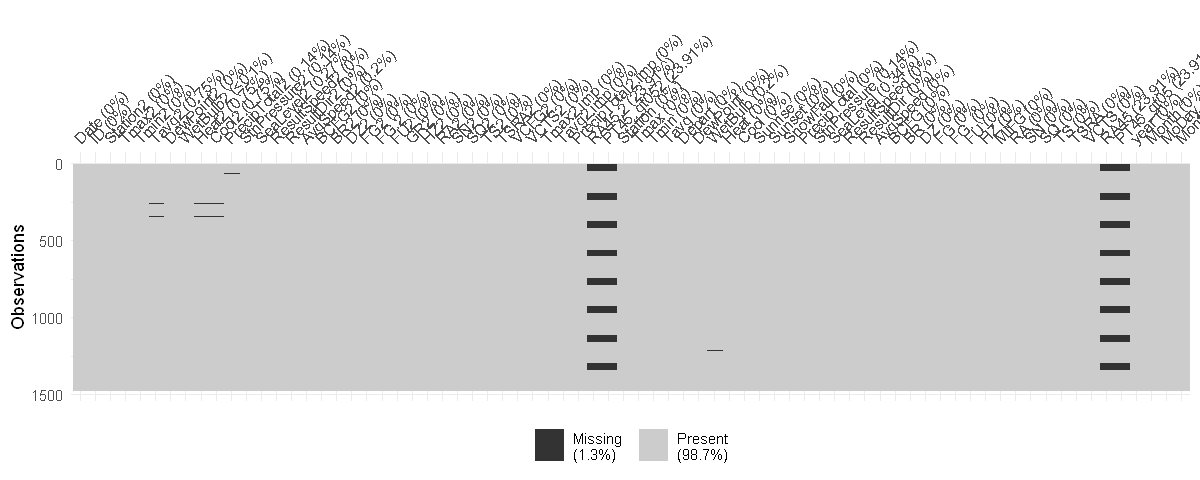

In [5]:
options(repr.plot.width = 10, repr.plot.height = 4)
vis_miss(w01)

In [6]:
colnames(w01)

[1] "Date"             "ID"               "Station2"         "Tmax2"           
 [5] "Tmin2"            "Tavg2"            "DewPoint2"        "WetBulb2"        
 [9] "Heat2"            "Cool2"            "PrecipTotal2"     "StnPressure2"    
[13] "SeaLevel2"        "ResultSpeed2"     "ResultDir2"       "AvgSpeed2"       
[17] "BCFG2"            "BR2"              "DZ2"              "FG2"             
[21] "FG.2"             "FU2"              "GR2"              "HZ2"             
[25] "RA2"              "SN2"              "SQ2"              "TS2"             
[29] "TSRA2"            "VCFG2"            "VCTS2"            "Tmax2.imp"       
[33] "Tavg2.imp"        "PrecipTotal2.imp" "RA45.2"           "PT45_gt052"      
[37] "Station"          "Tmax"             "Tmin"             "Tavg"            
[41] "Depart"           "DewPoint"         "WetBulb"          "Heat"            
[45] "Cool"             "Sunrise"          "Sunset"           "SnowFall"        
[49] "PrecipTotal"      "StnPressure"      "SeaLevel"         "ResultSpeed"     
[53] "ResultDir"        "AvgSpeed"         "BCFG"             "BR"              
[57] "DZ"               "FG"               "FG."              "FU"              
[61] "HZ"               "MIFG"             "RA"               "SN"              
[65] "SQ"               "TS"               "TSRA"             "VCTS"            
[69] "RA45"             "PT45_gt05"        "year"             "Month"           
[73] "MoDay"            "Month_Day"

In [ ]:
פונקציה GGPLOT


## Determinate the Missingness Generation Mechanism
 
There are three mechanisms that generate Missing values:
 
1. Missing Completely at Random (MCAR)
2. Missing at Random (MAR)
3. Missing not at Random (MNAR)
 
We will investigate the missingness mechanisms using different techniques.


In [ ]:
RA45	PT45_gt50	RA45_2

In [7]:
grep("RA45", colnames(w01))

[1] 35 69

In [8]:
grep("PT45_gt05", colnames(w01))

[1] 36 70

In [14]:
grep("StnPressure", colnames(w01))

[1] 12 50

In [17]:
grep("RA",colnames(w01))

[1] 25 29 35 63 67 69

In [18]:
# require(MissMech)
w01m <- w01[,c(2,4,8,25,29,50,49, 34 ,35,36,69,70)]
miss1 <- TestMCARNormality(data=w01m)
miss1

Call:
TestMCARNormality(data = w01m)

Number of Patterns:  2 

Total number of cases used in the analysis:  1469 

 Pattern(s) used:
          ID   Tmax2   WetBulb2   RA2   TSRA2   StnPressure   PrecipTotal
group.1    1       1          1     1       1             1             1
group.2    1       1          1     1       1             1             1
          PrecipTotal2.imp   RA45.2   PT45_gt052   RA45   PT45_gt05
group.1                  1       NA           NA     NA          NA
group.2                  1        1            1      1           1
          Number of cases
group.1               352
group.2              1117


    Test of normality and Homoscedasticity:
  -------------------------------------------

Hawkins Test:

    P-value for the Hawkins test of normality and homoscedasticity:  8.07739e-62 

    Either the test of multivariate normality or homoscedasticity (or both) is rejected.
    Provided that normality can be assumed, the hypothesis of MCAR is 
    rejected

In [19]:
### Impute missing values

miss1 <- TestMCARNormality(data=w01m, , del.lesscases = 1, imputation.number = 10)
summary(miss1)



Number of imputation:  10 

Number of Patterns:  3 

Total number of cases used in the analysis:  1471 

 Pattern(s) used:
          ID   Tmax2   WetBulb2   RA2   TSRA2   StnPressure   PrecipTotal
group.1    1       1          1     1       1             1             1
group.2    1       1          1     1       1             1             1
group.3    1       1          1     1       1            NA             1
          PrecipTotal2.imp   RA45.2   PT45_gt052   RA45   PT45_gt05
group.1                  1       NA           NA     NA          NA
group.2                  1        1            1      1           1
group.3                  1        1            1      1           1
          Number of cases
group.1               352
group.2              1117
group.3                 2


    Test of normality and Homoscedasticity:
  -------------------------------------------

Hawkins Test:

    P-value for the Hawkins test of normality and homoscedasticity:  4.903201e-63 

Non-Parametr

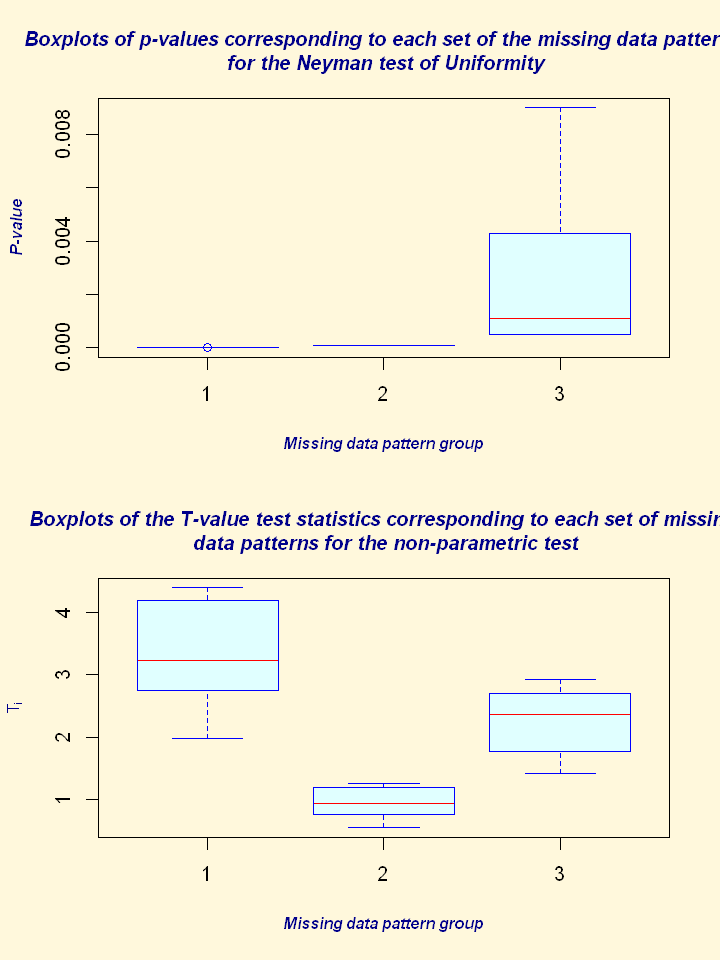

In [20]:
options(repr.plot.width = 6, repr.plot.height = 8)
boxplot(miss1)

In [21]:
summary(miss1$imputed.data)

w01.imp <- data.frame(miss1$imputed.data)
idx <- miss1$caseorder

head(w01.imp)
dim(w01.imp)

       ID             Tmax2           WetBulb2          RA2       
 Min.   :   1.0   Min.   : 41.00   Min.   : 2.00   Min.   :0.000  
 1st Qu.: 368.5   1st Qu.: 69.00   1st Qu.:22.00   1st Qu.:0.000  
 Median : 736.0   Median : 78.00   Median :30.00   Median :0.000  
 Mean   : 736.2   Mean   : 76.35   Mean   :28.59   Mean   :0.312  
 3rd Qu.:1103.5   3rd Qu.: 85.00   3rd Qu.:36.00   3rd Qu.:1.000  
 Max.   :1472.0   Max.   :104.00   Max.   :46.00   Max.   :1.000  
     TSRA2         StnPressure     PrecipTotal     PrecipTotal2.imp
 Min.   :0.0000   Min.   :28.55   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:0.0000   1st Qu.:29.16   1st Qu.:0.0000   1st Qu.:0.0000  
 Median :0.0000   Median :29.26   Median :0.0000   Median :0.0000  
 Mean   :0.1054   Mean   :29.25   Mean   :0.1344   Mean   :0.1283  
 3rd Qu.:0.0000   3rd Qu.:29.35   3rd Qu.:0.0600   3rd Qu.:0.0500  
 Max.   :1.0000   Max.   :29.79   Max.   :6.8600   Max.   :4.7300  
     RA45.2        PT45_gt052            RA45         P

ID,Tmax2,WetBulb2,RA2,TSRA2,StnPressure,PrecipTotal,PrecipTotal2.imp,RA45.2,PT45_gt052,RA45,PT45_gt05
1,84,26,0,0,29.10,0,0,15.74811,1.0023159,15.75511,0.9578708
2,60,16,0,0,29.38,0,0,12.24724,0.9357264,11.42741,0.8316392
3,67,19,0,0,29.39,0,0,16.15893,0.9136058,15.92101,0.8191412
4,78,19,0,0,29.31,0,0,10.95013,0.9232722,14.05338,0.7954528
5,66,19,0,0,29.40,0,0,17.26332,0.9707625,16.91719,0.9490688
6,68,15,0,0,29.57,0,0,17.03916,0.9470216,16.91410,0.9866144


[1] 1471   12

In [22]:
summary(w01[,c(2,4,8,25,29,50,49, 34 ,35,36,69,70)])

       ID             Tmax2           WetBulb2          RA2        
 Min.   :   1.0   Min.   : 41.00   Min.   : 2.00   Min.   :0.0000  
 1st Qu.: 368.8   1st Qu.: 69.00   1st Qu.:22.00   1st Qu.:0.0000  
 Median : 736.5   Median : 78.00   Median :30.00   Median :0.0000  
 Mean   : 736.5   Mean   : 76.35   Mean   :28.59   Mean   :0.3125  
 3rd Qu.:1104.2   3rd Qu.: 85.00   3rd Qu.:36.00   3rd Qu.:1.0000  
 Max.   :1472.0   Max.   :104.00   Max.   :46.00   Max.   :1.0000  
                                   NA's   :1                       
     TSRA2         StnPressure     PrecipTotal     PrecipTotal2.imp
 Min.   :0.0000   Min.   :28.55   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:0.0000   1st Qu.:29.16   1st Qu.:0.0000   1st Qu.:0.0000  
 Median :0.0000   Median :29.26   Median :0.0000   Median :0.0000  
 Mean   :0.1053   Mean   :29.25   Mean   :0.1345   Mean   :0.1286  
 3rd Qu.:0.0000   3rd Qu.:29.35   3rd Qu.:0.0600   3rd Qu.:0.0525  
 Max.   :1.0000   Max.   :29.79   Max.   :6.8600

In [23]:
write.csv(w01.imp, file="C:/Users/Chen/Project/data/w01.imp.csv", row.names =F)